In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
import math
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.layers import Permute, Input, ConvLSTM2D, BatchNormalization, Conv2D, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [4]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteI4CTWL/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimension 64x64

In [5]:
#sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
#sequences = np.swapaxes(sequences, 1, 4)
sequences = sequences/255
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [6]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [7]:
def image_generator(dataset, batchsize=16, seqlen=4):
    num_samples, num_frames, width, height, channels = dataset.shape

    while True:
        batch_x = np.zeros((batchsize, width, height, channels, seqlen-1))
        batch_y = np.zeros((batchsize, width, height, channels, 1))

        ran = np.random.randint(num_samples, size=batchsize)
        minibatch = dataset[ran]

        for i in range(batchsize):
            random_start = np.random.randint(0, num_frames - seqlen + 1)
            random_end = random_start + seqlen
            batch_x[i] = np.transpose(minibatch[i, random_start:random_end-1], (1, 2, 3, 0))
            batch_y[i] = np.transpose(minibatch[i, random_end-1:random_end], (1, 2, 3, 0))

        yield batch_x, batch_y


In [8]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)
print(prova_gen)

<generator object image_generator at 0x79d5a067c2e0>


In [9]:
sample_x, sample_y = next(prova_gen)
print(sample_x.shape)
print(sample_y.shape)

(1, 64, 64, 1, 3)
(1, 64, 64, 1, 1)


In [10]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

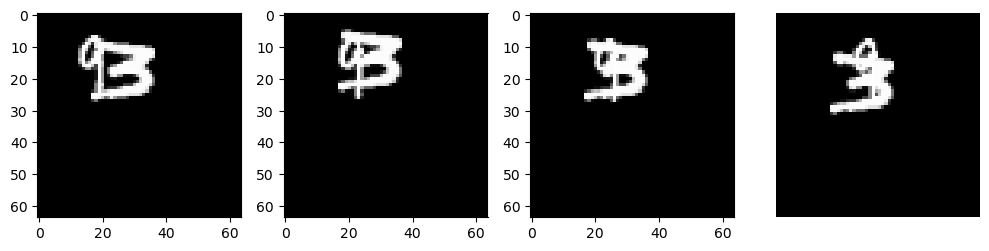

In [11]:
all = [sample_x[0, :, :, :, i] for i in range(3)] + [sample_y[0, :, :, :, 0]]
show_list(all)

In [12]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [13]:
sample_x, sample_y = next(train_gen)
print(sample_x.shape)
print(sample_y.shape)

(16, 64, 64, 1, 3)
(16, 64, 64, 1, 1)


In [14]:
def build_model():
    inputs = Input(shape=(64, 64, 1, 3))
    x = Permute((4, 1, 2, 3))(inputs)

    # Increase model depth and complexity
    x = ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding="same", return_sequences=False)(x)

    # Adjust filter sizes
    x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)

    # Incorporate skip connections
    skip = Conv2D(filters=32, kernel_size=(1, 1), activation="relu", padding="same")(inputs)
    skip = tf.squeeze(skip, axis=3)
    skip = Permute((2, 3, 1))(skip)
    skip = Reshape((64, 64, 32))(skip)
    x = Concatenate()([x, skip])

    # Adjust activation functions
    x = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", padding="same")(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [15]:
model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1,   0           []                               
                                3)]                                                               
                                                                                                  
 permute (Permute)              (None, 3, 64, 64, 1  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 3, 64, 64, 6  416256      ['permute[0][0]']                
                                4)                                                            

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

In [17]:
history = model.fit(train_gen, batch_size=3, validation_data=val_gen, steps_per_epoch=1000, validation_steps=100, epochs=20, callbacks = [early_stopping,reduce_lr])

Epoch 1/20
1000/1000 [==============================] - 355s 339ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0153 - val_mse: 0.0153 - lr: 0.0010
Epoch 2/20
1000/1000 [==============================] - 347s 347ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0150 - val_mse: 0.0150 - lr: 0.0010
Epoch 3/20
1000/1000 [==============================] - 338s 338ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0118 - val_mse: 0.0118 - lr: 0.0010
Epoch 4/20
1000/1000 [==============================] - 339s 339ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0117 - val_mse: 0.0117 - lr: 0.0010
Epoch 5/20
1000/1000 [==============================] - 339s 339ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0113 - val_mse: 0.0113 - lr: 0.0010
Epoch 6/20
1000/1000 [==============================] - 348s 348ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111 - lr: 0.0010
Epoch 7/20
1000/1000 [==============================] - 339s 339ms/step - loss: 0.0109 - mse: 

In [18]:
# Evaluate the model on the full test set
num_test_samples = testset.shape[0]
test_steps = math.ceil(num_test_samples / 16)  # Adjust batchsize if necessary

In [19]:
loss = model.evaluate(test_gen, steps=test_steps)

63/63 [==============================] - 7s 118ms/step - loss: 0.0097 - mse: 0.0097


In [20]:
print("Test Loss:", loss)

Test Loss: [0.009743797592818737, 0.009743797592818737]


1/1 [==============================] - 1s 689ms/step


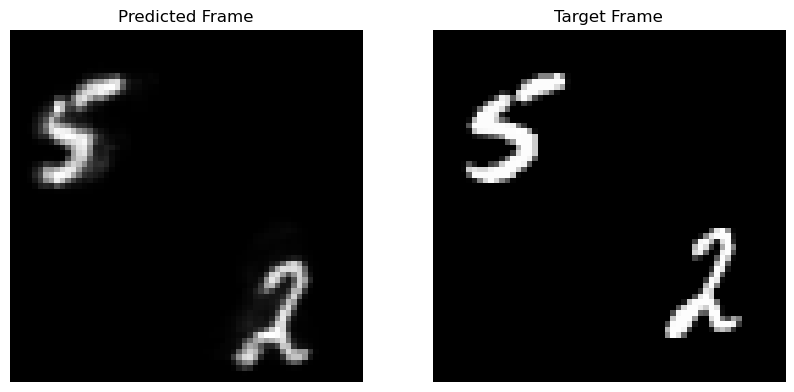

0.009322166490651892


In [21]:
def compare_frames(model, train_gen):
    # Retrieve a batch of input data from the generator
    input_data, target_data = next(train_gen)

    # Predict frames using the model
    predicted_frames = model.predict(input_data)

    # Get the last predicted frame and target frame
    predicted_frame = predicted_frames[:, :, :, -1]
    target_frame = target_data[:, :, :, -1]

    # Reshape target frame to match the predicted frame shape
    target_frame = np.squeeze(target_frame, axis=-1)

    # Plot the frames
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(predicted_frame[0], cmap='gray')
    axes[0].set_title('Predicted Frame')
    axes[0].axis('off')
    axes[1].imshow(target_frame[0], cmap='gray')
    axes[1].set_title('Target Frame')
    axes[1].axis('off')
    plt.show()

    return predicted_frame, target_frame


# Assuming 'model' is the trained model and 'train_gen' is the generator
predicted_frame, target_frame = compare_frames(model, train_gen)

# Compare the frames using any desired metric or analysis
mse = np.mean(np.square(predicted_frame - target_frame))

print(mse)

In [22]:
# Salvataggio del modello sulla scrivania
desktop_path = "/Users/alessandrofolloni/Scrivania/"
model.save(desktop_path + "modello.h5")


In [23]:
def calculate_mse(model, test_gen, num_samples):
    mse_sum = 0

    for _ in range(num_samples):
        batch_x, batch_y = next(test_gen)

        # Predict the next frame using the model
        predicted_frame = model.predict(batch_x)

        # Reshape batch_y if necessary
        batch_y = np.squeeze(batch_y, axis=-1)

        # Calculate MSE for the batch
        mse_sum += np.mean(np.square((predicted_frame - batch_y)))

    # Calculate the average MSE for the entire test set
    mse = mse_sum / num_samples

    return mse

# Assuming 'model' is the trained model and 'test_gen' is the test generator
num_samples = 1000  # Set the number of samples in your test set
mse = calculate_mse(model, test_gen, num_samples)

print("Overall MSE:", mse)


1/1 [==============================] - 0s 24ms/step
Overall MSE: 0.00976335639928101
